In [193]:
!pip install catboost -q
!pip install catboost phik shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 27.5 MB/s eta 0:00:00


In [194]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# catboost
from catboost import CatBoostRegressor, Pool

# feature importance
import shap
from sklearn.inspection import permutation_importance



In [278]:
# download data

data = pd.read_csv('/content/drive/MyDrive/AgroHack/data/train.csv')
pedigree = pd.read_csv('/content/drive/MyDrive/AgroHack/data/pedigree.csv')
test = pd.read_csv('/content/drive/MyDrive/AgroHack/data/X_test_public.csv')

# Data

In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155575 entries, 0 to 155574
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   animal_id      155575 non-null  object 
 1   lactation      155575 non-null  int64  
 2   calving_date   155575 non-null  object 
 3   farm           155575 non-null  int64  
 4   farmgroup      155575 non-null  int64  
 5   birth_date     155575 non-null  object 
 6   milk_yield_1   155575 non-null  float64
 7   milk_yield_2   155575 non-null  float64
 8   milk_yield_3   151068 non-null  float64
 9   milk_yield_4   151634 non-null  float64
 10  milk_yield_5   151457 non-null  float64
 11  milk_yield_6   150373 non-null  float64
 12  milk_yield_7   150938 non-null  float64
 13  milk_yield_8   151065 non-null  float64
 14  milk_yield_9   147880 non-null  float64
 15  milk_yield_10  126179 non-null  float64
dtypes: float64(10), int64(3), object(3)
memory usage: 19.0+ MB


In [280]:
data.head()

,animal_id,lactation,calving_date,farm,farmgroup,birth_date,milk_yield_1,milk_yield_2,milk_yield_3,milk_yield_4,milk_yield_5,milk_yield_6,milk_yield_7,milk_yield_8,milk_yield_9,milk_yield_10
0,ID_0000732131,1,2018-11-11,2104,4463,2016-10-02,19.2,21.4,NaN,30.7,28.6,28.1,NaN,31.1,25.5,26.1
1,ID_0000732194,1,2013-05-01,2104,4463,2011-05-19,16.7,15.9,14.4,20.4,14.3,23.2,21.0,22.0,23.3,22.5
2,ID_0000732195,1,2013-05-17,2104,4463,2011-06-01,15.8,14.4,19.3,23.1,31.8,24.7,30.9,32.3,32.7,33.1
3,ID_0000732195,2,2014-06-16,2104,4463,2011-06-01,43.7,39.9,39.2,33.2,40.3,44.8,39.3,40.1,40.5,37.7
4,ID_0000732338,1,2013-05-18,2104,4463,2011-07-11,13.8,13.2,29.9,26.4,31.3,17.6,25.8,25.6,24.5,19.8


In [281]:
# make features as datetime

data['calving_date'] = pd.to_datetime(data['calving_date'])
data['birth_date'] = pd.to_datetime(data['birth_date'])

test['calving_date'] = pd.to_datetime(test['calving_date'])
test['birth_date'] = pd.to_datetime(test['birth_date'])

In [282]:
# define targets

targets = ['milk_yield_' + str(i) for i in range(3, 11)]
all_targets = ['milk_yield_' + str(i) for i in range(1, 11)]

data[targets].describe()

,milk_yield_3,milk_yield_4,milk_yield_5,milk_yield_6,milk_yield_7,milk_yield_8,milk_yield_9,milk_yield_10
count,151068.000000,151634.000000,151457.000000,150373.000000,150938.000000,151065.000000,147880.000000,126179.000000
mean,32.775544,31.566198,30.047933,28.441747,26.942042,25.255298,23.338780,21.666913
std,10.927027,10.739861,10.246589,9.693483,9.340448,9.085511,8.994968,8.957548
min,0.500000,1.000000,0.469000,0.235000,0.295000,0.335000,0.200000,0.300000
25%,25.100000,24.000000,22.700000,21.300000,20.000000,18.600000,16.800000,15.200000
50%,31.000000,29.900000,28.600000,27.100000,25.900000,24.300000,22.500000,20.800000
75%,38.900000,37.700000,36.100000,34.500000,32.966667,31.066667,29.200000,27.600000
max,87.000000,78.200000,78.200000,92.200000,70.800000,70.400000,68.000000,98.900000


# EDA

As we can see, mean of targets gets higher every year.

It's better to use data only after 2019 because in test set we have samples only from 2021 and 2022.

<Axes: xlabel='calving_date'>

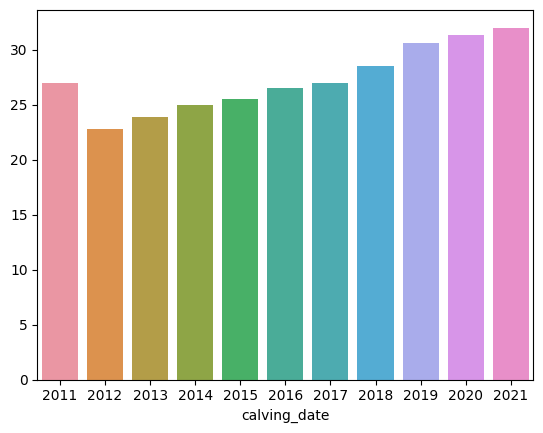

In [91]:
sns.barplot(x=data.groupby(data['calving_date'].dt.year)[all_targets].mean().mean(axis=1).index,
            y=data.groupby(data['calving_date'].dt.year)[all_targets].mean().mean(axis=1).values)

In [92]:
data = data[data['calving_date'].dt.year >= 2019]

Luckily, we have enough samples to train and to validate models

In [151]:
len(data)

39171

Distribution of lactations

(array([24529.,     0.,     0., 18232.,     0.,     0., 11152.,     0.,
            0.,  6177.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

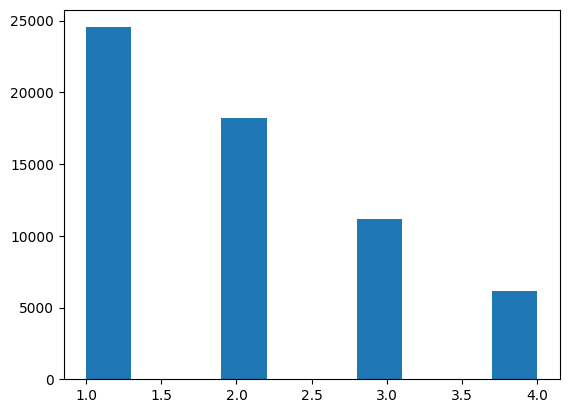

In [93]:
plt.hist(data['lactation'])

(array([5259.,    0.,    0., 3534.,    0.,    0., 2080.,    0.,    0.,
        1105.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

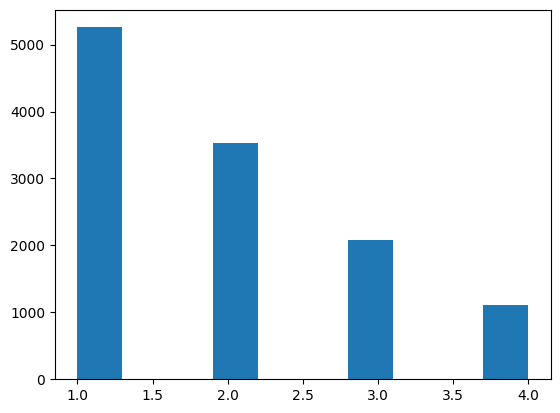

In [283]:
plt.hist(test['lactation'])

Распределение уникальных тестовых данных (информации о которых не было в трэине)

Коров, которые уникальны (не видели на трэине) на второй и третьей лактации мало, можно этим пренебречь

<Axes: >

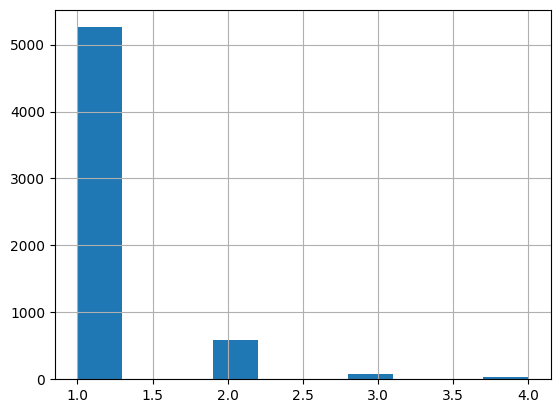

In [94]:
# unique id for test
ids = set(test['animal_id'].values) - set(data['animal_id'].values)
test[test['animal_id'].isin(ids)]['lactation'].hist()

Распределение данных о лактации коров, которые уже были в train

<Axes: >

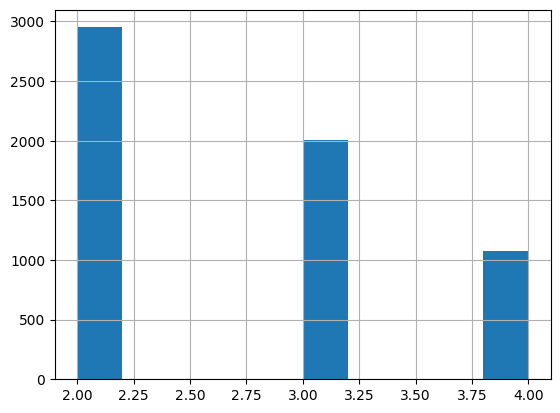

In [95]:
# not unique id for test
ids = set(test['animal_id'].values) & set(data['animal_id'].values)
test[test['animal_id'].isin(ids)]['lactation'].hist()

# New features

In [96]:
data = data.reset_index().drop('index', axis=1)

In [97]:
data.head()

,animal_id,lactation,calving_date,farm,farmgroup,birth_date,milk_yield_1,milk_yield_2,milk_yield_3,milk_yield_4,milk_yield_5,milk_yield_6,milk_yield_7,milk_yield_8,milk_yield_9,milk_yield_10
0,ID_0000732786,1,2020-09-28,2104,4463,2018-11-01,27.2,27.2,38.0,38.5,40.3,42.1,43.4,41.0,40.3,34.1
1,ID_0000732825,1,2021-01-21,2105,4463,2018-10-09,38.6,39.2,39.8,39.3,38.1,29.0,28.8,27.0,27.0,24.0
2,ID_0000732875,1,2020-06-09,2105,4463,2018-04-04,33.5,35.7,36.8,31.7,30.7,27.9,30.6,32.3,26.3,26.1
3,ID_0000732914,1,2020-02-29,2104,4463,2018-05-09,28.2,28.2,33.3,34.9,35.3,34.7,33.0,31.3,31.9,30.8
4,ID_0000732914,2,2021-03-21,2104,4463,2018-05-09,30.7,47.6,53.4,30.0,35.5,45.2,38.2,37.0,40.6,38.3


**Age of the cow**

We can get the age of the cow by subtracting the date of birth from the date of lactation

In [98]:
data['age'] = (data['calving_date'] - data['birth_date']).dt.days
test['age'] = (test['calving_date'] - test['birth_date']).dt.days

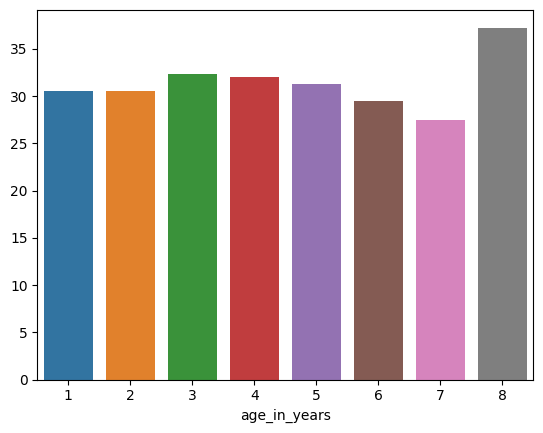

In [99]:
data['age_in_years'] = data['age'] // 365
sns.barplot(x=data.groupby('age_in_years')[all_targets].mean().mean(axis=1).index,
            y=data.groupby('age_in_years')[all_targets].mean().mean(axis=1).values)
data.drop('age_in_years', axis=1, inplace=True)

**Calving and birth month**

In [100]:
data['calving_month'] = data['calving_date'].dt.month
test['calving_month'] = test['calving_date'].dt.month

data['birth_month'] = data['birth_date'].dt.month
test['birth_month'] = test['birth_date'].dt.month


**Amounn of days from previous lactation of the cow**

In [101]:
data = data.sort_values(by=['animal_id', 'lactation'])

In [102]:
data['date_diff'] = data.groupby('animal_id')['calving_date'].diff().dt.days

In [103]:
data['date_diff'] = data['date_diff'].fillna(-1)

**Mean from previous lactation for each cow**

For example, if we have to predict the value for the 3 lactation and we already have the values from first and second lactations, we can use them and incrase score

In [128]:
def get_average_previous(targets, lactation):
  return data[data['lactation'] < lactation].groupby('animal_id')[targets].mean().to_dict()

In [105]:
%%time
for target in all_targets:
  data['mean_previous_' + target] = [-1 for i in range(len(data))]
  test['mean_previous_' + target] = [-1 for i in range(len(test))]
  for lactation in [2, 3, 4]:
    dicts = get_average_previous(target, lactation)
    data['mean_previous_' + target] = (data['mean_previous_' + target]).where(data['lactation'] < lactation, data['animal_id'].apply(lambda x: dicts[x] if x in dicts.keys() else -1))
    test['mean_previous_' + target] = (test['mean_previous_' + target]).where(test['lactation'] < lactation, test['animal_id'].apply(lambda x: dicts[x] if x in dicts.keys() else -1))

CPU times: user 3.57 s, sys: 19.8 ms, total: 3.59 s
Wall time: 3.81 s


**Amount of calves**

In [129]:
amount_of_children = pedigree.groupby('mother_id')['animal_id'].count().to_dict()

data['amount_children'] = data['animal_id'].apply(lambda x: amount_of_children[x] if x in amount_of_children.keys() else 0)
test['amount_children'] = test['animal_id'].apply(lambda x: amount_of_children[x] if x in amount_of_children.keys() else 0)

As we can see, usually the more children, the more milk

<Axes: xlabel='amount_children'>

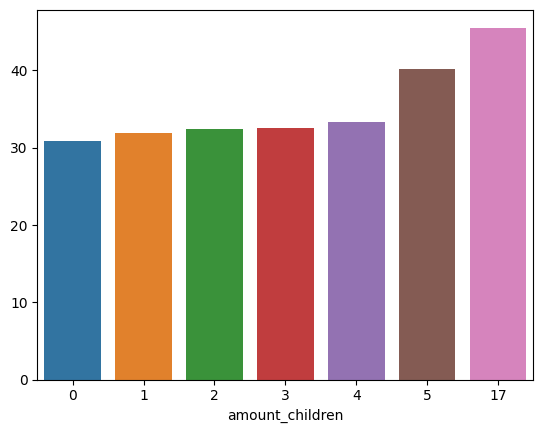

In [130]:
sns.barplot(x=data.groupby('amount_children')[all_targets].mean().mean(axis=1).index,
            y=data.groupby('amount_children')[all_targets].mean().mean(axis=1).values)

**Difference between lactation and calve birth**

Let's suppose that if a cow has recently given birth, she gives more milk

Define this way:

-1 - no any children

0 - day difference between lactation abd birth < 10

1 - day difference between lactation abd birth > 10

In [140]:
children_dict = pedigree.groupby('mother_id')['animal_id'].apply(list).to_dict()

In [132]:
%%time
birth_dict = {}

t = data.drop_duplicates(subset='animal_id')[['animal_id', 'birth_date']]
for i in range(len(t)):
    birth_dict[t.iloc[i]['animal_id']] = t.iloc[i]['birth_date']


CPU times: user 8.2 s, sys: 26 ms, total: 8.23 s
Wall time: 8.3 s


In [133]:
def get_children_births(id, calving_date):
    # id of children
    if id not in children_dict.keys():
        return -1
    children = children_dict[id]

    # get births of children
    children_births = []
    for i in children:
        if i in birth_dict.keys():
            children_births.append(birth_dict[i])
        else:
            continue

    # посчитать разницу между birth и сhildren_births
    diffrerences = []

    for child_birth in children_births:
        # Print(child_birth, birth)
        # print(birth - child_birth)
        diffrerences.append(calving_date - child_birth)



    if diffrerences:
        return min(diffrerences).days
    return -1




In [134]:
data['min_child_born'] = [0 for i in range(len(data))]
data['min_child_born'] = data.apply(lambda x: get_children_births(x['animal_id'],x['calving_date']), axis=1)

test['min_child_born'] = [0 for i in range(len(test))]
test['min_child_born'] = test.apply(lambda x: get_children_births(x['animal_id'],x['calving_date']), axis=1)

In [135]:
def to_cat(x):
    if x == -1:
        return -1
    elif x <= 10:
        return 0
    return 1

data['min_child_born'] = data['min_child_born'].apply(lambda x: to_cat(x))
test['min_child_born'] = test['min_child_born'].apply(lambda x: to_cat(x))

Unfortunatelly, there is not any cow  with 0 label in test set, that is why this featuree is not useful

In [137]:
test['min_child_born'].value_counts()

-1    11557
 1      421
Name: min_child_born, dtype: int64

**Average mother's milk yield**

In [141]:
%%time
mother_dict = {}
for i in range(len(pedigree)):
    mother_dict[pedigree.iloc[i]['animal_id']] = pedigree.iloc[i]['mother_id']

CPU times: user 11.2 s, sys: 33.9 ms, total: 11.2 s
Wall time: 11.5 s


In [142]:
dict_mother_average = data.groupby('animal_id')[all_targets].mean().mean(axis=1).to_dict()


def get_average_mother(id):

    if id not in mother_dict.keys():
        return -1
    mother_id = mother_dict[id]
    if mother_id not in dict_mother_average.keys():
        return -1
    return dict_mother_average[mother_id]

In [143]:
%%time

data['average_mother'] = data['animal_id'].apply(lambda x: get_average_mother(x))
test['average_mother'] = test['animal_id'].apply(lambda x: get_average_mother(x))


CPU times: user 112 ms, sys: 855 µs, total: 113 ms
Wall time: 117 ms


****Average grandmothers's milk yield****

In [144]:
%%time
mother_dict = {}
for i in range(len(pedigree)):
    mother_dict[pedigree.iloc[i]['animal_id']] = pedigree.iloc[i]['mother_id']

CPU times: user 13.9 s, sys: 48.8 ms, total: 13.9 s
Wall time: 18.9 s


In [145]:
data['mother_id'] = data['animal_id'].apply(lambda x: mother_dict[x] if x in mother_dict.keys() else -1)
data['father_id'] = data['animal_id'].apply(lambda x: mother_dict[x] if x in mother_dict.keys() else -1)


In [146]:
%%time

data['average_grandmother_1'] = data['mother_id'].apply(lambda x: get_average_mother(x))
data['average_grandmother_2'] = data['father_id'].apply(lambda x: get_average_mother(x))

CPU times: user 136 ms, sys: 21 µs, total: 136 ms
Wall time: 141 ms


In [147]:
data.drop(['mother_id', 'father_id'], axis=1, inplace=True)

**Удалим пропущенные в таргете**

In [148]:
data.dropna(subset=targets, inplace=True)

In [149]:
data.head()

,animal_id,lactation,calving_date,farm,farmgroup,birth_date,milk_yield_1,milk_yield_2,milk_yield_3,milk_yield_4,...,mean_previous_milk_yield_6,mean_previous_milk_yield_7,mean_previous_milk_yield_8,mean_previous_milk_yield_9,mean_previous_milk_yield_10,amount_children,min_child_born,average_mother,average_grandmother_1,average_grandmother_2
0,ID_0000732786,1,2020-09-28,2104,4463,2018-11-01,27.2,27.2,38.0,38.5,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,-1.000000,-1.0,-1.0
1,ID_0000732825,1,2021-01-21,2105,4463,2018-10-09,38.6,39.2,39.8,39.3,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,-1.000000,-1.0,-1.0
2,ID_0000732875,1,2020-06-09,2105,4463,2018-04-04,33.5,35.7,36.8,31.7,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,18.977778,-1.0,-1.0
3,ID_0000732914,1,2020-02-29,2104,4463,2018-05-09,28.2,28.2,33.3,34.9,...,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1,-1.000000,-1.0,-1.0
4,ID_0000732914,2,2021-03-21,2104,4463,2018-05-09,30.7,47.6,53.4,30.0,...,34.7,33.0,31.3,31.9,30.8,1,-1,-1.000000,-1.0,-1.0


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39171 entries, 0 to 60088
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   animal_id                    39171 non-null  object        
 1   lactation                    39171 non-null  int64         
 2   calving_date                 39171 non-null  datetime64[ns]
 3   farm                         39171 non-null  int64         
 4   farmgroup                    39171 non-null  int64         
 5   birth_date                   39171 non-null  datetime64[ns]
 6   milk_yield_1                 39171 non-null  float64       
 7   milk_yield_2                 39171 non-null  float64       
 8   milk_yield_3                 39171 non-null  float64       
 9   milk_yield_4                 39171 non-null  float64       
 10  milk_yield_5                 39171 non-null  float64       
 11  milk_yield_6                 39171 non-nu

# Create validation set

Будем делить по такому принципу:

1)В тесте все данные либо новой коровы (которой не было в трэине), либо последней лактации известной коровы. Во избежании ситуации, когда на тренировачной выборке есть данные о третьей лактации коровы, а на валидации надо предсказать значения второй лактации этой же коровы, мы оставим на валидацю только данные последней лактации (через drop_duplicates)

2)чтобы было на чем валидироваться, в валидацию будем брать сэмплы без нанов

3)Возьмем коров за 2021 год, так как в тесте 2022

<Axes: >

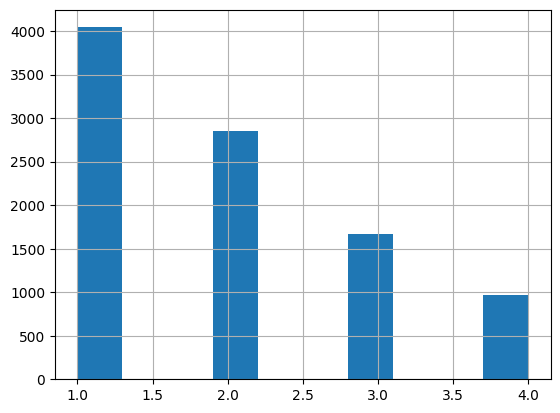

In [152]:
data_for_split = data.drop_duplicates(subset='animal_id', keep='last')
data_for_split = data_for_split[data_for_split['calving_date'].dt.year == 2021]
data_for_split['lactation'].hist()

In [153]:
data_for_split['lactation'].value_counts()

1    4044
2    2851
3    1667
4     970
Name: lactation, dtype: int64

In [154]:
test['lactation'].value_counts()

1    5259
2    3534
3    2080
4    1105
Name: lactation, dtype: int64

We need to choose

4 lactation - 1,100

3 lactation - 2100

2 lactation - 3500

1 lactation 5000

In [155]:
data_for_split.head()

,animal_id,lactation,calving_date,farm,farmgroup,birth_date,milk_yield_1,milk_yield_2,milk_yield_3,milk_yield_4,...,mean_previous_milk_yield_6,mean_previous_milk_yield_7,mean_previous_milk_yield_8,mean_previous_milk_yield_9,mean_previous_milk_yield_10,amount_children,min_child_born,average_mother,average_grandmother_1,average_grandmother_2
1,ID_0000732825,1,2021-01-21,2105,4463,2018-10-09,38.6,39.2,39.8,39.3,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,-1.000000,-1.0,-1.0
4,ID_0000732914,2,2021-03-21,2104,4463,2018-05-09,30.7,47.6,53.4,30.0,...,34.7,33.0,31.3,31.9,30.8,1,-1,-1.000000,-1.0,-1.0
12,ID_0000733412,1,2021-08-29,2105,4463,2019-07-08,15.0,40.9,41.1,42.4,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,43.920000,-1.0,-1.0
29,ID_0000733713,1,2021-08-26,2105,4463,2019-07-15,25.0,36.4,28.4,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,44.393333,-1.0,-1.0
35,ID_0000733768,2,2021-09-25,2107,4463,2018-11-01,28.3,43.2,32.5,29.9,...,28.5,26.9,26.9,22.0,NaN,0,-1,38.177778,-1.0,-1.0


In [156]:
lacatation_4 = data_for_split[data_for_split['lactation'] == 4].sample(970, random_state=42).index.values
lacatation_3 = data_for_split[data_for_split['lactation'] == 3].sample(1667, random_state=42).index.values
lacatation_2 = data_for_split[data_for_split['lactation'] == 2].sample(2851, random_state=42).index.values
lacatation_1 = data_for_split[data_for_split['lactation'] == 1].sample(4044, random_state=42).index.values

In [157]:
val_ids = list(np.concatenate([lacatation_4, lacatation_3, lacatation_2, lacatation_1]))
len(val_ids)

9532

In [158]:
train_data = data[~data.index.isin(val_ids)]
val_data = data[data.index.isin(val_ids)]

Distributions of validation and test sets are similar enough

<Axes: >

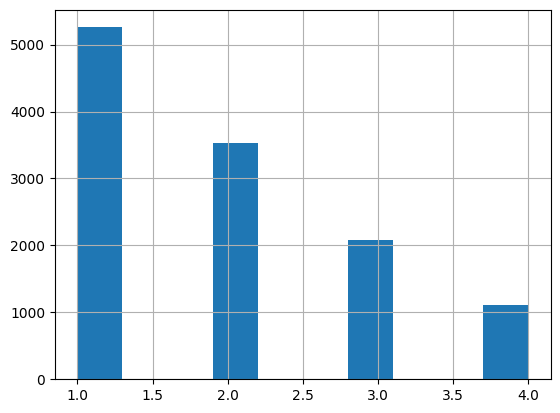

In [160]:
test['lactation'].hist()

<Axes: >

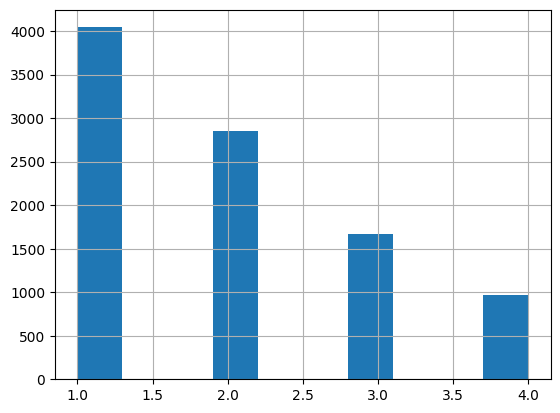

In [159]:
val_data['lactation'].hist()

# CatBoost

In [251]:
train_data_cat = train_data.copy(deep=True)
val_data_cat = val_data.copy(deep=True)
pred_data_cat = val_data.copy(deep=True)

In [252]:
train_data_cat.head()

,animal_id,lactation,calving_date,farm,farmgroup,birth_date,milk_yield_1,milk_yield_2,milk_yield_3,milk_yield_4,...,mean_previous_milk_yield_6,mean_previous_milk_yield_7,mean_previous_milk_yield_8,mean_previous_milk_yield_9,mean_previous_milk_yield_10,amount_children,min_child_born,average_mother,average_grandmother_1,average_grandmother_2
0,ID_0000732786,1,2020-09-28,2104,4463,2018-11-01,27.2,27.2,38.0,38.5,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,-1.000000,-1.0,-1.0
2,ID_0000732875,1,2020-06-09,2105,4463,2018-04-04,33.5,35.7,36.8,31.7,...,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1,18.977778,-1.0,-1.0
3,ID_0000732914,1,2020-02-29,2104,4463,2018-05-09,28.2,28.2,33.3,34.9,...,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1,-1.000000,-1.0,-1.0
6,ID_0000732998,1,2019-04-17,2105,4463,2017-05-04,23.2,28.0,27.5,26.4,...,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,-1.000000,-1.0,-1.0
7,ID_0000732998,2,2020-08-25,2105,4463,2017-05-04,30.0,14.0,27.3,27.2,...,23.8,23.7,19.5,22.4,21.5,1,1,-1.000000,-1.0,-1.0


In [253]:
len(train_data_cat)

29639

In [254]:
train_data_cat.columns

Index(['animal_id', 'lactation', 'calving_date', 'farm', 'farmgroup',
       'birth_date', 'milk_yield_1', 'milk_yield_2', 'milk_yield_3',
       'milk_yield_4', 'milk_yield_5', 'milk_yield_6', 'milk_yield_7',
       'milk_yield_8', 'milk_yield_9', 'milk_yield_10', 'age', 'calving_month',
       'birth_month', 'date_diff', 'mean_previous_milk_yield_1',
       'mean_previous_milk_yield_2', 'mean_previous_milk_yield_3',
       'mean_previous_milk_yield_4', 'mean_previous_milk_yield_5',
       'mean_previous_milk_yield_6', 'mean_previous_milk_yield_7',
       'mean_previous_milk_yield_8', 'mean_previous_milk_yield_9',
       'mean_previous_milk_yield_10', 'amount_children', 'min_child_born',
       'average_mother', 'average_grandmother_1', 'average_grandmother_2'],
      dtype='object')

In [255]:
# in order to see score in train set later
train_true_target = train_data_cat[targets]

In [256]:
# defina cat_features
cat_features = ['lactation', 'farm', 'farmgroup', 'animal_id', 'calving_month', 'birth_month']

In [257]:
train_data_cat[cat_features] = train_data_cat[cat_features].astype('category')
val_data_cat[cat_features] = val_data_cat[cat_features].astype('category')

In [258]:
# define params
# we will use one model for one target (there are 8 targets)

n_estimators = [200000 for i in range(8)]

params_cat = [{
    "n_estimators": n_estimators[i],
    #'learning_rate':0.02,
    'loss_function': 'MAE',
    # max depth
    "depth": 6,
    # features
    'colsample_bylevel': 0.8,
    # samples
    'subsample': 0.8,
    'early_stopping_rounds': 30,
    'cat_features': cat_features,
    'verbose':False,
    'random_state': 777,
    'thread_count': -1,
    # НА ИНФЕРЕНСЕ УДАЛИТЬ
    # 'task_type':'GPU',
} for i in range(len(targets))]


In [259]:
# train models with early stopping

# array of models
models = []

for index, target in enumerate(targets):

    # define model
    cat = CatBoostRegressor(**params_cat[index])

    # define Pool dataset (special for CatBoost) for train and validation
    train_dataset = Pool(data=train_data_cat.drop(targets, axis=1), label=train_data_cat[target], cat_features=cat_features)
    eval_dataset = Pool(data=val_data_cat.drop(targets, axis=1), label=val_data_cat[target], cat_features=cat_features)

    # training
    cat.fit(train_dataset,
            eval_set=eval_dataset,
            use_best_model=True
            )
    # predict
    train_data_cat[target] = cat.predict(train_data_cat.drop(targets, axis=1))
    pred_data_cat[target] = cat.predict(pred_data_cat.drop(targets, axis=1))


    models.append(cat)

## Metrics

### Train

In [271]:
# train score for aech target
loss_array = [MSE(train_true_target['milk_yield_' + str(i)], train_data_cat['milk_yield_' + str(i)], squared=False) for i in range(3, 11)]
loss_array

[5.2360799263784195,
 5.701566617185034,
 5.9176353778400115,
 5.690502249408044,
 5.348630145144151,
 5.536717314883487,
 5.592079582415592,
 6.061944384521563]

<Axes: >

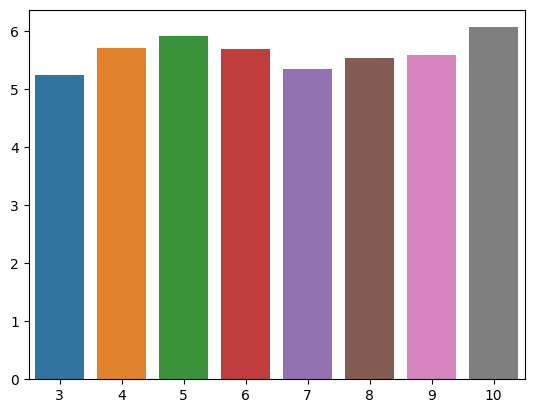

In [272]:
sns.barplot(x=[i for i in range(3, 11)],
            y=loss_array)

In [273]:
# mean score
sum(loss_array) / len(loss_array)

5.6356444497220375

### Validation

In [262]:
# val score for aech target
loss_array = [MSE(val_data_cat['milk_yield_' + str(i)], pred_data_cat['milk_yield_' + str(i)], squared=False) for i in range(3, 11)]
loss_array

[6.046900129578453,
 6.632857002084562,
 6.77841461699447,
 6.558985380262041,
 6.530001894980896,
 6.5596734414943825,
 6.794999644215539,
 7.2778088307442514]

In [263]:
# mean score
sum(loss_array) / len(loss_array)

6.6474551175443235

# Feature importance

In [223]:
# train_data_cat = train_data.copy(deep=True)
# val_data_cat = val_data.copy(deep=True)
# pred_data_cat = val_data.copy(deep=True)

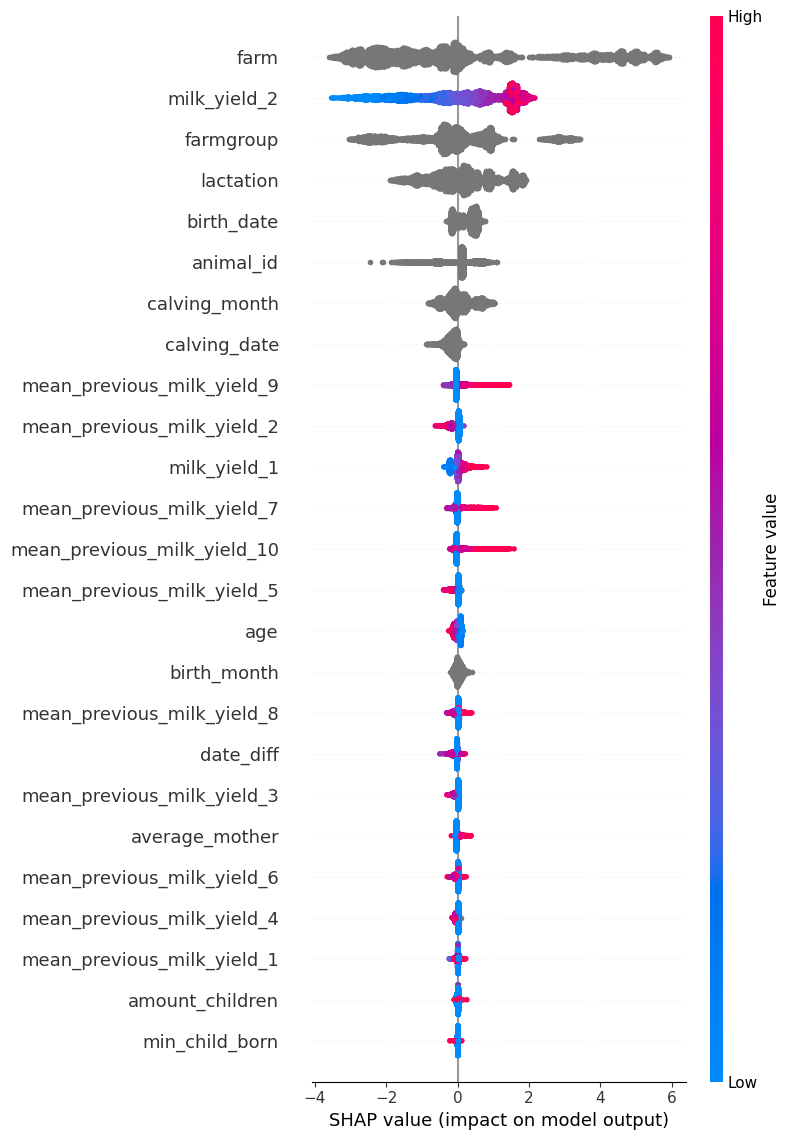

In [274]:
explainer = shap.TreeExplainer(models[-1])

val_dataset = Pool(data=val_data_cat.drop(targets, axis=1), label=val_data_cat[targets[-1]], cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, val_data_cat.drop(targets, axis=1), max_display = 25)

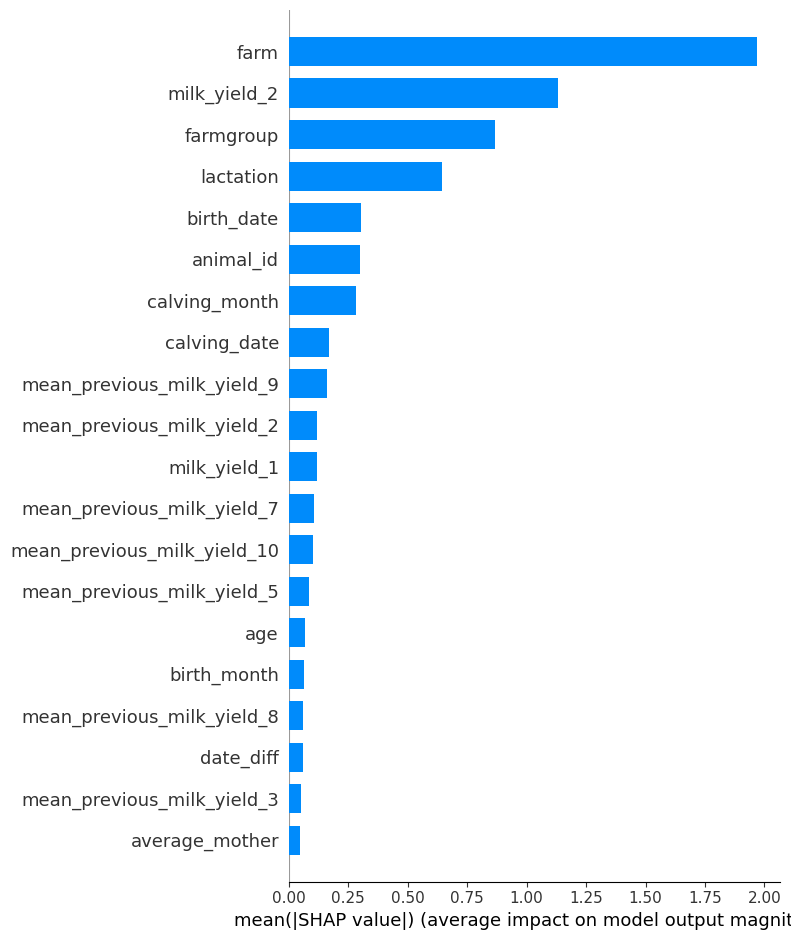

In [275]:
shap.summary_plot(
    shap_values, val_data_cat.drop(targets, axis=1), feature_names=val_data_cat.drop(targets, axis=1).columns, plot_type="bar"
)

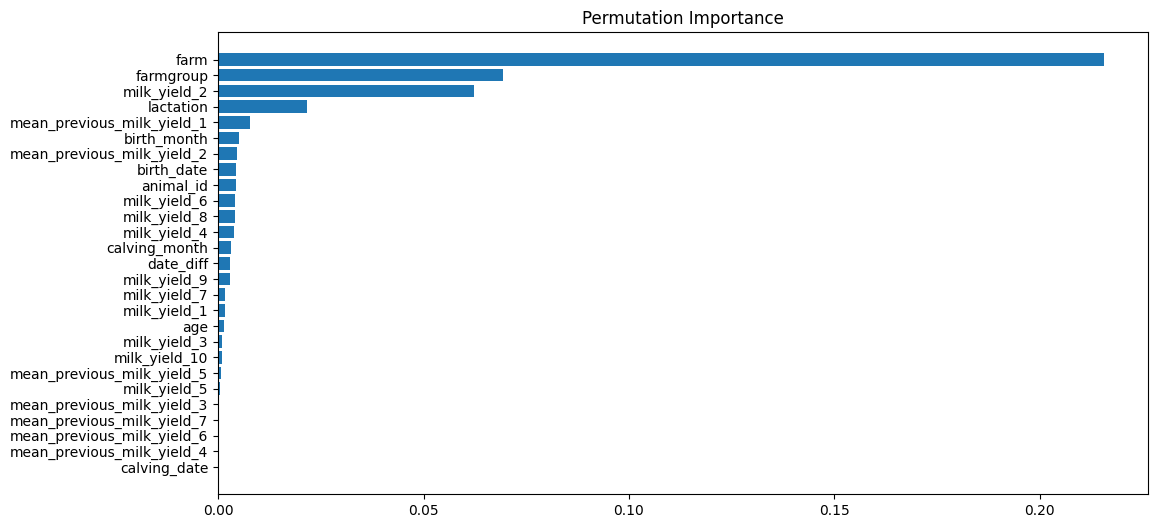

In [277]:
perm_importance = permutation_importance(models[-1], val_data_cat.drop(targets, axis=1), val_data_cat[targets[-1]], n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(data.columns)[sorted_idx])
plt.title('Permutation Importance');